Will be using a PIBOSO dataset found online. 
> So it looks like PIBOSO is suited to sentence level classification, as it has some extra classes to be defined and already contains an 'other' label?

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

PATH_TRAIN = 'train.csv'

train_df = pd.read_csv(PATH_TRAIN)
train_df = train_df[train_df.Prediction!= 0]
train_df.head(20)

,Prediction,Label,Document,Sentence,Text
4,1,other,10072623,1,OBJECTIVES
6,1,background,10072623,2,We wanted to evaluate the urodynamic changes o...
7,1,intervention,10072623,2,We wanted to evaluate the urodynamic changes o...
8,1,population,10072623,2,We wanted to evaluate the urodynamic changes o...
16,1,other,10072623,3,METHODS
20,1,population,10072623,4,Sixty-six consecutive patients (mean age 68 ye...
28,1,other,10072623,5,RESULTS
33,1,outcome,10072623,6,Complete urinary continence was achieved in 37...
39,1,outcome,10072623,7,Stress incontinence of varying degree improved...
45,1,outcome,10072623,8,Seven patients demonstrated a moderate inconti...


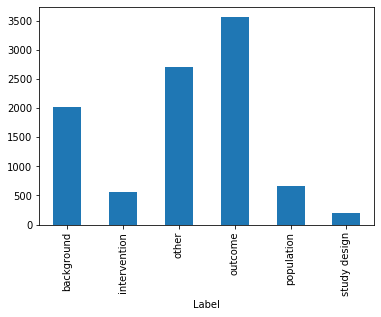

In [2]:
train_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()


In [3]:

train_df = train_df.assign(ID=(train_df['Label']).astype('category').cat.codes)
train_df.head(10)


,Prediction,Label,Document,Sentence,Text,ID
4,1,other,10072623,1,OBJECTIVES,2
6,1,background,10072623,2,We wanted to evaluate the urodynamic changes o...,0
7,1,intervention,10072623,2,We wanted to evaluate the urodynamic changes o...,1
8,1,population,10072623,2,We wanted to evaluate the urodynamic changes o...,4
16,1,other,10072623,3,METHODS,2
20,1,population,10072623,4,Sixty-six consecutive patients (mean age 68 ye...,4
28,1,other,10072623,5,RESULTS,2
33,1,outcome,10072623,6,Complete urinary continence was achieved in 37...,3
39,1,outcome,10072623,7,Stress incontinence of varying degree improved...,3
45,1,outcome,10072623,8,Seven patients demonstrated a moderate inconti...,3


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train_df.Text).toarray()
labels = train_df.ID
features.shape

(9727, 5376)

In [5]:
category_id_df = train_df[['Label', 'ID']].drop_duplicates().sort_values('ID')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['ID', 'Label']].values)
train_df.head(10)

,Prediction,Label,Document,Sentence,Text,ID
4,1,other,10072623,1,OBJECTIVES,2
6,1,background,10072623,2,We wanted to evaluate the urodynamic changes o...,0
7,1,intervention,10072623,2,We wanted to evaluate the urodynamic changes o...,1
8,1,population,10072623,2,We wanted to evaluate the urodynamic changes o...,4
16,1,other,10072623,3,METHODS,2
20,1,population,10072623,4,Sixty-six consecutive patients (mean age 68 ye...,4
28,1,other,10072623,5,RESULTS,2
33,1,outcome,10072623,6,Complete urinary continence was achieved in 37...,3
39,1,outcome,10072623,7,Stress incontinence of varying degree improved...,3
45,1,outcome,10072623,8,Seven patients demonstrated a moderate inconti...,3


In [6]:
from sklearn.feature_selection import chi2

import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print('\n')

# 'background':
  . Most correlated unigrams:
. conclusions
. results
  . Most correlated bigrams:
. injury tbi
. injury sci


# 'intervention':
  . Most correlated unigrams:
. received
. mg
  . Most correlated bigrams:
. mg kg
. randomized receive


# 'other':
  . Most correlated unigrams:
. conclusions
. results
  . Most correlated bigrams:
. selection criteria
. main results


# 'outcome':
  . Most correlated unigrams:
. methods
. results
  . Most correlated bigrams:
. 95 ci
. lt 05


# 'population':
  . Most correlated unigrams:
. consecutive
. recruited
  . Most correlated bigrams:
. consecutive patients
. year old


# 'study design':
  . Most correlated unigrams:
. retrospective
. prospective
  . Most correlated bigrams:
. systematic review
. cross sectional




In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['Label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


/Users/johndoe/PycharmProjects/AT_VU/venv-py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/johndoe/PycharmProjects/AT_VU/venv-py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sc

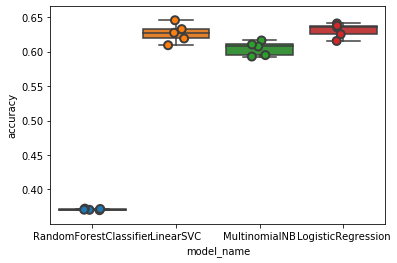

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.626707
LogisticRegression        0.630820
MultinomialNB             0.604296
RandomForestClassifier    0.371029
Name: accuracy, dtype: float64

In [52]:
train_df.head(10)

,Prediction,Label,Document,Sentence,Text,ID
4,1,other,10072623,1,OBJECTIVES,2
6,1,background,10072623,2,We wanted to evaluate the urodynamic changes o...,0
7,1,intervention,10072623,2,We wanted to evaluate the urodynamic changes o...,1
8,1,population,10072623,2,We wanted to evaluate the urodynamic changes o...,4
16,1,other,10072623,3,METHODS,2
20,1,population,10072623,4,Sixty-six consecutive patients (mean age 68 ye...,4
28,1,other,10072623,5,RESULTS,2
33,1,outcome,10072623,6,Complete urinary continence was achieved in 37...,3
39,1,outcome,10072623,7,Stress incontinence of varying degree improved...,3
45,1,outcome,10072623,8,Seven patients demonstrated a moderate inconti...,3


In [14]:
y_test


36519         outcome
13943    study design
1899          outcome
16820      population
40008      background
             ...     
2163          outcome
2347     intervention
4227          outcome
22455         outcome
37768           other
Name: Label, Length: 2432, dtype: object